Note:  
This notebook was executed on google colab pro.

In [1]:
!pip3 install pytorch-lightning --quiet

     |████████████████████████████████| 813 kB 14.1 MB/s 
     |████████████████████████████████| 234 kB 50.1 MB/s 
     |████████████████████████████████| 10.6 MB 48.0 MB/s 
     |████████████████████████████████| 118 kB 97.3 MB/s 
     |████████████████████████████████| 829 kB 57.3 MB/s 
     |████████████████████████████████| 636 kB 60.5 MB/s 
     |████████████████████████████████| 1.3 MB 81.0 MB/s 
     |████████████████████████████████| 142 kB 89.2 MB/s 
     |████████████████████████████████| 294 kB 88.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires tensorboard~=2.5, but you have tensorboard 2.4.1 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/atmacup11/experiments')

# Settings

In [4]:
EXP_NO = 21
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

In [5]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

In [6]:
MODEL_NAME = 'resnet'
BATCH_SIZE = 128
NUM_EPOCHS = 200

# Library

In [7]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
# from sklearnex import patch_sklearn
from pytorch_lightning import seed_everything
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torchvision import transforms

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile,load_photofiles, AtmaImageDatasetV02
from folder import experiment_dir_of
from models import initialize_model
from utils import train_model, predict_by_model

In [8]:
pd.options.display.float_format = '{:.5f}'.format

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Prepare directory

In [10]:
output_dir = experiment_dir_of(EXP_NO)

In [11]:
output_dir

'../scripts/../experiments/exp021'

# Prepare logger

In [12]:
logger = getLogger(__name__)

In [13]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [14]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-21 04:38:07,368 - __main__ - INFO - Experiment no: 21
2021-07-21 04:38:07,370 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-21 04:38:07,372 - __main__ - INFO - SEED: 1
2021-07-21 04:38:07,375 - __main__ - INFO - REGRESSION: True


# Load csv files

In [15]:
SINCE = time.time()

In [16]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-21 04:38:07,390 - __main__ - DEBUG - Start loading csv files (0.007 seconds passed)
2021-07-21 04:38:09,296 - __main__ - DEBUG - Complete loading csv files (1.913 seconds passed)


In [17]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [18]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Cross validation

In [19]:
seed_everything(SEED)

Global seed set to 1


1

In [20]:
train.set_index('object_id', inplace=True)

2021-07-21 04:38:09,991 - __main__ - DEBUG - Start fold 1 (2.609 seconds passed)
2021-07-21 04:38:09,998 - __main__ - DEBUG - Start training model (2.615 seconds passed)
2021-07-21 04:38:16,120 - __main__ - DEBUG - Epoch 0/199
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
2021-07-21 04:43:36,608 - __main__ - DEBUG - train Loss: 2.3381
2021-07-21 04:44:57,093 - __main__ - DEBUG - val Loss: 1.8269
2021-07-21 04:44:57,103 - __main__ - DEBUG - Epoch 1/199
2021-07-21 04:45:03,846 - __main__ - DEBUG - train Loss: 0.8963
2021-07-21 04:45:05,728 - __main__ - DEBUG - val Loss: 0.9984
2021-07-21 04:45:05,741 - __main__ - DEBUG - Epoch 2/199
202

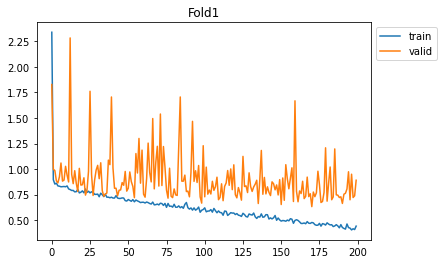

2021-07-21 05:13:22,500 - __main__ - DEBUG - Complete prediction for train fold (2115.117 seconds passed)
2021-07-21 05:13:24,226 - __main__ - DEBUG - Complete prediction for val fold (2116.843 seconds passed)
2021-07-21 05:21:08,670 - __main__ - DEBUG - Complete prediction for test fold (2581.288 seconds passed)
2021-07-21 05:21:08,692 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp021/cv_fold1_training.csv (2581.310 seconds passed)
2021-07-21 05:21:08,702 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp021/cv_fold1_validation.csv (2581.319 seconds passed)
2021-07-21 05:21:08,727 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp021/cv_fold1_test.csv (2581.344 seconds passed)
2021-07-21 05:21:08,917 - __main__ - DEBUG - Save model ../scripts/../experiments/exp021/cv_fold1_model.torch (2581.534 seconds passed)
2021-07-21 05:21:09,028 - __main__ - DEBUG - Complete fold 1 (2581.645 seconds passed)
2021-07-21 05:21:09,029

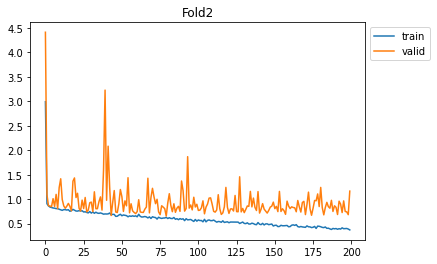

2021-07-21 05:49:41,701 - __main__ - DEBUG - Complete prediction for train fold (4294.318 seconds passed)
2021-07-21 05:49:43,387 - __main__ - DEBUG - Complete prediction for val fold (4296.004 seconds passed)
2021-07-21 05:49:53,839 - __main__ - DEBUG - Complete prediction for test fold (4306.456 seconds passed)
2021-07-21 05:49:53,857 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp021/cv_fold2_training.csv (4306.474 seconds passed)
2021-07-21 05:49:53,868 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp021/cv_fold2_validation.csv (4306.485 seconds passed)
2021-07-21 05:49:53,892 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp021/cv_fold2_test.csv (4306.509 seconds passed)
2021-07-21 05:49:54,039 - __main__ - DEBUG - Save model ../scripts/../experiments/exp021/cv_fold2_model.torch (4306.656 seconds passed)
2021-07-21 05:49:54,141 - __main__ - DEBUG - Complete fold 2 (4306.759 seconds passed)
2021-07-21 05:49:54,143

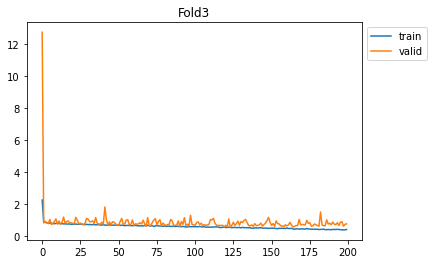

2021-07-21 06:18:32,621 - __main__ - DEBUG - Complete prediction for train fold (6025.238 seconds passed)
2021-07-21 06:18:34,372 - __main__ - DEBUG - Complete prediction for val fold (6026.989 seconds passed)
2021-07-21 06:18:44,248 - __main__ - DEBUG - Complete prediction for test fold (6036.865 seconds passed)
2021-07-21 06:18:44,265 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp021/cv_fold3_training.csv (6036.882 seconds passed)
2021-07-21 06:18:44,274 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp021/cv_fold3_validation.csv (6036.891 seconds passed)
2021-07-21 06:18:44,294 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp021/cv_fold3_test.csv (6036.911 seconds passed)
2021-07-21 06:18:44,429 - __main__ - DEBUG - Save model ../scripts/../experiments/exp021/cv_fold3_model.torch (6037.046 seconds passed)
2021-07-21 06:18:44,535 - __main__ - DEBUG - Complete fold 3 (6037.152 seconds passed)
2021-07-21 06:18:44,537

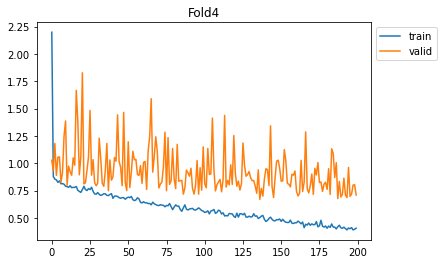

2021-07-21 06:47:30,500 - __main__ - DEBUG - Complete prediction for train fold (7763.117 seconds passed)
2021-07-21 06:47:32,343 - __main__ - DEBUG - Complete prediction for val fold (7764.960 seconds passed)
2021-07-21 06:47:42,695 - __main__ - DEBUG - Complete prediction for test fold (7775.312 seconds passed)
2021-07-21 06:47:42,714 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp021/cv_fold4_training.csv (7775.331 seconds passed)
2021-07-21 06:47:42,733 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp021/cv_fold4_validation.csv (7775.350 seconds passed)
2021-07-21 06:47:42,754 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp021/cv_fold4_test.csv (7775.371 seconds passed)
2021-07-21 06:47:42,895 - __main__ - DEBUG - Save model ../scripts/../experiments/exp021/cv_fold4_model.torch (7775.512 seconds passed)
2021-07-21 06:47:43,011 - __main__ - DEBUG - Complete fold 4 (7775.629 seconds passed)
2021-07-21 06:47:43,014

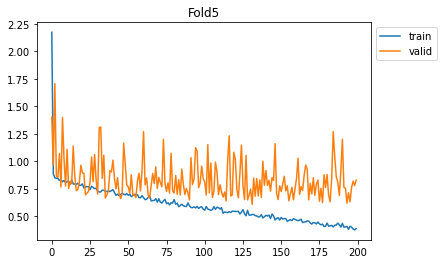

2021-07-21 07:16:35,646 - __main__ - DEBUG - Complete prediction for train fold (9508.263 seconds passed)
2021-07-21 07:16:37,401 - __main__ - DEBUG - Complete prediction for val fold (9510.018 seconds passed)
2021-07-21 07:16:47,536 - __main__ - DEBUG - Complete prediction for test fold (9520.154 seconds passed)
2021-07-21 07:16:47,558 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp021/cv_fold5_training.csv (9520.175 seconds passed)
2021-07-21 07:16:47,578 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp021/cv_fold5_validation.csv (9520.195 seconds passed)
2021-07-21 07:16:47,601 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp021/cv_fold5_test.csv (9520.218 seconds passed)
2021-07-21 07:16:47,739 - __main__ - DEBUG - Save model ../scripts/../experiments/exp021/cv_fold5_model.torch (9520.356 seconds passed)
2021-07-21 07:16:47,860 - __main__ - DEBUG - Complete fold 5 (9520.477 seconds passed)


In [21]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    y_train = train.loc[train_object_ids, TARGET].values
    y_valid = train.loc[valid_object_ids, TARGET].values

    torch.cuda.empty_cache()
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Prepare model
    model, input_size = initialize_model(MODEL_NAME)
    model.to(DEVICE)
    ## Prepare transformers
    train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transformer = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Prepare dataset
    train_dataset = AtmaImageDatasetV02(train_object_ids, train_transformer, y_train)
    val_dataset = AtmaImageDatasetV02(valid_object_ids, val_transformer, y_valid)
    # Prepare dataloader
    dataloaders = {
        'train': DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()),
        'val': DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()),
    }
    ## train estimator
    estimator, train_losses, valid_losses = train_model(
        model, dataloaders, criterion=nn.MSELoss(), num_epochs=NUM_EPOCHS, device=DEVICE,
        optimizer=torch.optim.Adam(model.parameters()), log_func=logger.debug,
        is_inception=MODEL_NAME == 'inception')
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Visualize training loss
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend(loc='upper left', bbox_to_anchor=[1., 1.])
    plt.title(f'Fold{num_fold}')
    plt.show()
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        predictions = {}
        for fold_, object_ids_ in zip(['train', 'val', 'test'],
                                     [train_object_ids, valid_object_ids, test['object_id']]):
            # Prepare transformer
            transformer_ = transforms.Compose([
                transforms.Resize(input_size),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            # Prepare dataset
            dataset_ = AtmaImageDatasetV02(object_ids_, transformer_)
            # Prepare dataloader
            dataloader_ = DataLoader(dataset=dataset_, batch_size=BATCH_SIZE, shuffle=False,
                                     num_workers=os.cpu_count())
            # Prediction
            predictions[fold_] = predict_by_model(estimator, dataloader_, DEVICE)
            logger.debug('Complete prediction for {} fold ({:.3f} seconds passed)' \
                         .format(fold_, time.time() - SINCE))
        pred_train = pd.DataFrame(data=predictions['train'], columns=['pred'])
        pred_valid = pd.DataFrame(data=predictions['val'], columns=['pred'])
        pred_test = pd.DataFrame(data=predictions['test'], columns=['pred'])
    else:  # Do not come here!
        raise NotImplemented
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.torch')
    torch.save(estimator.state_dict(), filepath_fold_model)
#     with open(filepath_fold_model, 'wb') as f:
#         pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Evaluation

In [22]:
rmse = partial(mean_squared_error, squared=False)

In [23]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [24]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [25]:
metrics = defaultdict(list)

## Training set

In [26]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-21 07:16:47,917 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-21 07:16:47,943 - __main__ - DEBUG - Loss: 0.5876571299641549
2021-07-21 07:16:47,944 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-21 07:16:47,955 - __main__ - DEBUG - Loss: 0.7121268426350972
2021-07-21 07:16:47,955 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-21 07:16:47,965 - __main__ - DEBUG - Loss: 0.6621587082368466
2021-07-21 07:16:47,966 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-21 07:16:47,977 - __main__ - DEBUG - Loss: 0.6345336874422894
2021-07-21 07:16:47,978 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-21 07:16:47,991 - __main__ - DEBUG - Loss: 0.63643029132397


In [27]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,1.15437,1
00309fb1ef05416f9c1f,1.94865,3
003a1562e97f79ba96dc,2.11921,3
004890880e8e7431147b,0.72189,2
00718c32602425f504c1,2.05508,3
...,...,...
ffa3259fff8e6f3818a1,2.30110,3
ffd4d361756587883e48,0.99262,1
ffd794b7b311b7b7fd92,1.78939,2


In [28]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-21 07:16:48,040 - __main__ - INFO - Training loss: 0.7410707262721846


In [29]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-21 07:16:48,062 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp021/prediction_train.csv


## Validation set

In [30]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-21 07:16:48,085 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-21 07:16:48,095 - __main__ - DEBUG - Loss: 0.7952032275529528
2021-07-21 07:16:48,097 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-21 07:16:48,106 - __main__ - DEBUG - Loss: 0.8084386196655036
2021-07-21 07:16:48,107 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-21 07:16:48,116 - __main__ - DEBUG - Loss: 0.75001875805724
2021-07-21 07:16:48,117 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-21 07:16:48,126 - __main__ - DEBUG - Loss: 0.817779730221752
2021-07-21 07:16:48,127 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-21 07:16:48,134 - __main__ - DEBUG - Loss: 0.7794267627613888


In [31]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.22868,1
00309fb1ef05416f9c1f,0.50787,3
003a1562e97f79ba96dc,0.49414,3
004890880e8e7431147b,0.16436,2
00718c32602425f504c1,0.58280,3
...,...,...
ffa3259fff8e6f3818a1,0.52759,3
ffd4d361756587883e48,0.28009,1
ffd794b7b311b7b7fd92,0.39505,2


In [32]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-21 07:16:48,172 - __main__ - INFO - Validatino loss: 1.6989879954817069


In [33]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-21 07:16:48,197 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp021/prediction_valid.csv


In [34]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-21 07:16:48,212 - __main__ - DEBUG - Write metrics to ../scripts/../experiments/exp021/metrics.json


# Prediction

In [35]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [36]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,1.02247
000bd5e82eb22f199f44,2.18125
0015f44de1854f617516,2.00854
00388a678879ba1efa27,2.16402
005e1e7c6496902d23f3,0.49825
...,...
ffbe65ad399b632dcbd0,2.17332
ffd7b2d646c0320c311a,0.96133
ffdb93ede17d4501e530,1.53618


In [37]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1.02247
1,2.18125
2,2.00854
3,2.16402
4,0.49825
...,...
5914,2.17332
5915,0.96133
5916,1.53618
5917,1.96426


In [38]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [39]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-21 07:16:48,358 - __main__ - DEBUG - Write submission to ../scripts/../experiments/exp021/021_submission.csv


2021-07-21 07:16:48,498 - __main__ - DEBUG - Write figure to ../scripts/../experiments/exp021/prediction.png


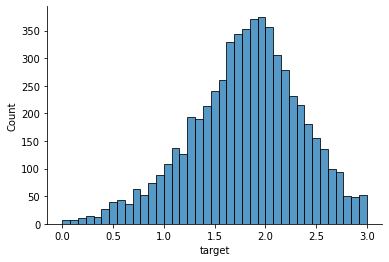

In [40]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [41]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-21 07:16:48,683 - __main__ - DEBUG - Complete (9521.300 seconds passed)
